# Solving Connections with Word2Vec

A little experiment to see if Word2Vec is helpful in solving the [New York Times Connections game](https://www.nytimes.com/games/connections). 
Dataset: https://huggingface.co/datasets/wikitext

In [5]:
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

import IPython
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

Let's see how this dataset is structured

In [6]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("wikitext")
ds_builder.info.features

{'text': Value(dtype='string', id=None)}

In [7]:
from datasets import load_dataset

dataset = load_dataset("wikitext", split="train", ignore_verifications=True)

/Users/jangerritsen/anaconda3/envs/nyt_connnections_conda_env/lib/python3.11/site-packages/datasets/load.py:1748: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
Found cached dataset parquet (/Users/jangerritsen/.cache/huggingface/datasets/parquet/wikitext-103-raw-v1-56fa33b81059af9d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [8]:
import re 
texts=[]
for element in tqdm(dataset):
  text = re.sub('[^a-zA-Z]' , ' ', element['text'])
  if len(text) == 0: 
    continue
  text = text.lower()
  text = text.split()
  x = len(text) if text.count('https') ==0  else text.index('https') 
  text = text[: x ]
  text = [t for t in text if not t=='https']
  text = ' '.join(text)
  texts.append(text)
    
print(f'texts has {len(texts)} items')

  0%|          | 0/3676136 [00:00<?, ?it/s]

texts has 2377592 items


Let's make sure stuff actually went in

In [9]:
for i in range(10):
    print(texts[i][0:100])

valkyria chronicles iii
senj no valkyria unrecorded chronicles japanese lit valkyria of the battlefield commonly referred to
the game began development in carrying over a large portion of the work done on valkyria chronicles 
it met with positive sales in japan and was praised by both japanese and western critics after relea
gameplay
as with previous valkyira chronicles games valkyria chronicles iii is a tactical role playing game w
the game s battle system the blitz system is carried over directly from valkyira chronicles during m
troops are divided into five classes scouts shocktroopers engineers lancers and armored soldier troo
plot
the game takes place during the second europan war gallian army squad also known as the nameless are


Split the data up into words

In [10]:
sentences = []
for text in tqdm(texts):
    sentences.append(text.split())

  0%|          | 0/2377592 [00:00<?, ?it/s]

Load the data into a Word2Vec model. This may take a couple of minutes

In [11]:
my_model = Word2Vec(sentences)
my_model.save("wikitext_model.model")

Checking that similarity makes sense

In [12]:
vector = my_model.wv['cat']  # get numpy vector of a word
sims = my_model.wv.most_similar('cat', topn=10)  # get other similar words
for sim in sims:
    print(sim)

('dog', 0.7727859020233154)
('hound', 0.7238338589668274)
('mouse', 0.7085729837417603)
('burglar', 0.6937995553016663)
('rabbit', 0.6731827855110168)
('feline', 0.6638152599334717)
('poodle', 0.6535183191299438)
('chipmunk', 0.6532942652702332)
('hounds', 0.65143221616745)
('beetle', 0.6491872072219849)


Not too bad. Checking the similarity between a cat and a dog, vs a cat and a potato

In [13]:
print(my_model.wv.similarity("cat", "dog"))

0.7727859


In [14]:
print(my_model.wv.similarity("cat", "potato"))

0.42728233


Define the function to display the plot. Adapted from 
[Text similarity with word embeddings in Gensim](https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229)

In [15]:
def display_words_tsnescatterplot(model: Word2Vec, word_array: []):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = word_array.copy()
    
    # add the vector for each of the closest words to the array

    for wrd_score in word_array:
        wrd_vector = model.wv[wrd_score]
        word_labels.append(wrd_score)
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

First test with a trivial example

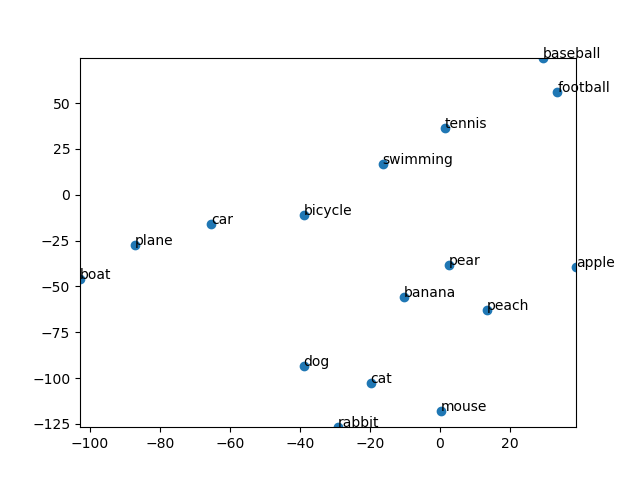

In [16]:
simple_test_word_array = ['apple', 'cat', 'dog', 'pear', 'car', 'bicycle', 'plane', \
                          'rabbit', 'banana', 'peach', 'boat', 'mouse', 'football', 'baseball', 'tennis', 'swimming']
display_words_tsnescatterplot(my_model, simple_test_word_array)

That works. Animals, transportation, fruits and sports are grouped (somewhat). Now for a real test. This was the 
[original challenge](https://drive.google.com/file/d/1NxsRK0zGWaXfiX25EVUlacJ4pHmFo5cN/view?usp=sharing")


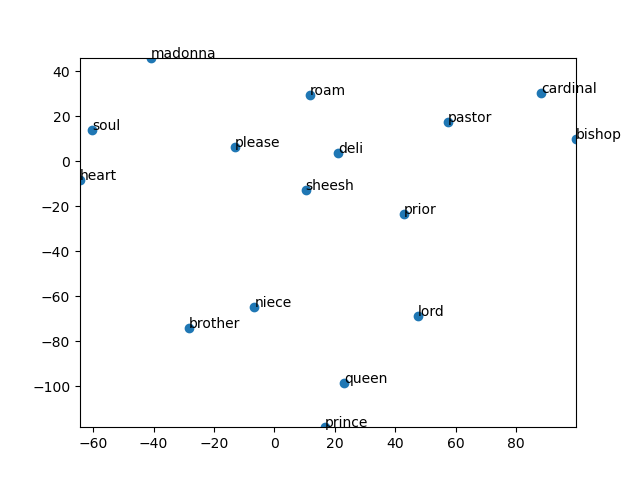

In [17]:
plt.close() # clear the plot graph
actual_word_array = 'bishop brother queen deli heart \
                     niece soul prince cardinal lord madonna \
                     prior pastor roam sheesh please'.split()

display_words_tsnescatterplot(my_model, actual_word_array)

Well, at least prior, pastor, cardinal and bishop are somewhat close to each other. Let's try another one.

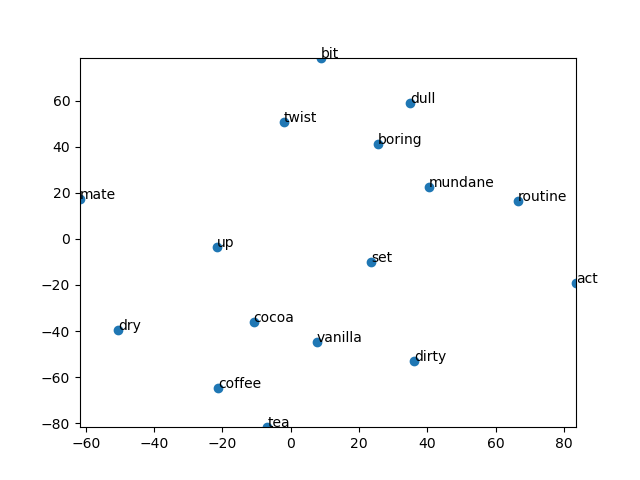

In [18]:
plt.close() # clear the plot graph
actual_word_array = 'act boring cocoa dirty \
                     bit dull coffee dry \
                     routine mate mundane twist \
                     set vanilla tea up'.split()
display_words_tsnescatterplot(my_model, actual_word_array)

Dull, boring, mundane, and routine are somewhat close together. Tea, coffee, cocoa as well, But 'mate', a south american drink is not close to those. This is a known problem of Word2Vec, where words that have multiple meanings are not handled well.

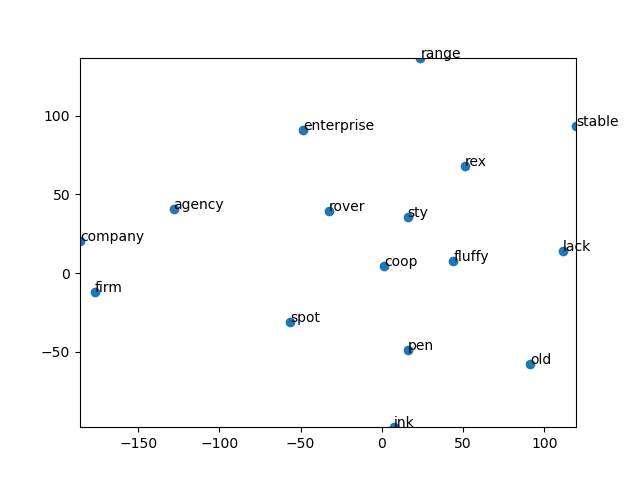

In [19]:
plt.close() # clear the plot graph
actual_word_array = 'agency company enterprise firm \
                     coop pen stable sty \
                     fluffy rex rover spot \
                     ink lack old range'.split()
display_words_tsnescatterplot(my_model, actual_word_array)

Again, not perfect. I would have expected enterprise to be closer to the firm/company/agency group. Oh well, it seems that this little experiment is not going to help me much in solving the Connections puzzle. 